In [33]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [34]:
dataset = 'model/keypoint_classifier/data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [35]:
NUM_CLASSES = 2

# Dataset reading

In [36]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [37]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [40]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092 (4.27 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [42]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [43]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5938 - loss: 0.6820
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5976 - loss: 0.6758 - val_accuracy: 0.9093 - val_loss: 0.6265
Epoch 2/1000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6016 - loss: 0.6613
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6406 - loss: 0.6604 - val_accuracy: 0.9537 - val_loss: 0.5979
Epoch 3/1000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7188 - loss: 0.6171
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6894 - loss: 0.6275 - val_accuracy: 0.9653 - val_loss: 0.5684
Epoch 4/1000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6953 - loss: 0.6148
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.kera

In [44]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0081


In [45]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [46]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[4.969828e-04 9.995030e-01]
1


# Confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


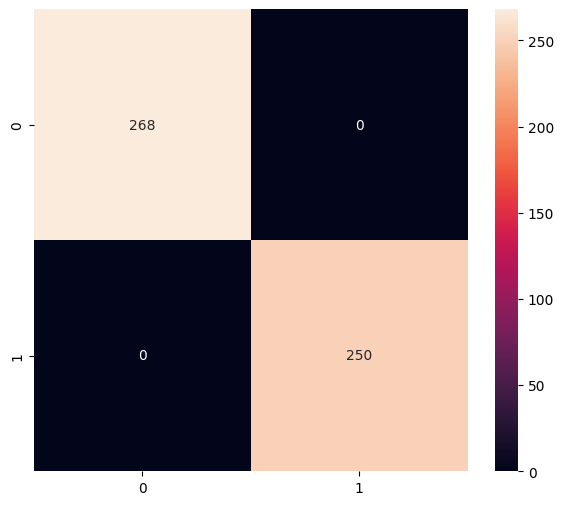

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       250

    accuracy                           1.00       518
   macro avg       1.00      1.00      1.00       518
weighted avg       1.00      1.00      1.00       518



In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [48]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [49]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmplzhfee17\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmplzhfee17\assets


Saved artifact at 'C:\Users\USER\AppData\Local\Temp\tmplzhfee17'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2393783566800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2393783573904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2393783571216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2393783567568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2393783578704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2393783567760: TensorSpec(shape=(), dtype=tf.resource, name=None)


6452

# Inference test

In [50]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [51]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [52]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [53]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.9698347e-04 9.9950302e-01]
1
